# Assignment 3: DLT, Two-View Geometry and PnP



# 1. Camera Calibration [DLT and Variants]

Briefly explain DLT and it's shortcomings. Refer to the provide rubik's image and follow the below points for deliverables:

1. Generate 2D-3D correspondences. Check provided code for selecting points on an image in below cells. Take a corresponding world co-ordinate for each chosen image points. You have the freedom to chose which point you want as origin. You can consider each side as 4 units. Ensure that the ordering of your points matches the ordering of image points. Keep track of the sequence of corners clicked.

2. Implement a function that accepts these correspondences and return estimated P matrix.
    Quick recap: $$x_i = P * X_i  where (x_i, X_i)$$ is the ith correspondence, and P is a 3x4 dimensional matrix. P is further decomposed as P = K * [ R | T].

3. Visualize the world points on the image using P matrix and report reprojection error of your P matrix for the same correspondences. You need to implement three different functions named `get_reprojected_points(P, X_world)`, `visualise(P, X_world, img_path)` and `get_reprojection_err(P, X_world, X_image)`.

4. Write the function that returns K, R, t given P as an argument. Next use `np.isclose()` to verify the R,K,T values.

5. Read upon Ransac based DLT and Zhangs method for camera caliberation and write the steps involved in each.

![Cube](./data/1/dlt1.jpeg)

### Explanation of DLT
- DLT, or Direct Linear Transform, addresses the problem of guessing the camera calibration matrix for an uncalibrated camera, that is, it guesses both the extrinsics and intrinsics of the camera (without separating them, in its basic form).
- Given: An image point $\mathbf{x}$ and the corresponding world point $\mathbf{X}$ 
- Given: $P$ is the camera calibration matrix. 
$$
\begin{align}
\mathbf{x}_{3 \times 1} &= K_{3 \times 3}R_{3 \times 3}\left[I_{3 \times 3} \vert -\mathbf{t}_{3 \times 1} \right]\mathbf{X}_{4 \times 1} \\
\implies \mathbf{x}_{3 \times 1} &= P_{3 \times 4}\mathbf{X}_{4 \times 1}
\end{align}
$$


We divide by the third and fourth coordinate in $\mathbf{x}$ and $\mathbf{X}$ respectively to get
$$
\begin{bmatrix}
x \\
y \\
1 \\
\end{bmatrix} = P
\begin{bmatrix}
X \\
Y \\
Z \\
1 \\
\end{bmatrix}
$$

$$
\begin{align}
x &= \frac{p_{11}X + p_{12}Y + p_{13}Z + p_{14}}{p_{31}X + p_{32}Y + p_{33}Z + p_{34}} \\
y &= \frac{p_{21}X + p_{22}Y + p_{23}Z + p_{24}}{p_{31}X + p_{32}Y + p_{33}Z + p_{34}}
\end{align}
$$

$$
\mathbf{x_i} = 
\begin{bmatrix}
A^T \\
B^T \\
C^T \\
\end{bmatrix}
\mathbf{X}_i
$$
where $A^T, B^T, C^T$ are the rows of $P$.

We can represent the individual coordinates as:
$$
x_i = \frac{A^T \mathbf{X_i}}{C^T \mathbf{X_i}} \\
y_i = \frac{B^T \mathbf{X_i}}{C^T \mathbf{X_i}}
$$
$$
\implies
x_i C^T \mathbf{X_i} - A^T \mathbf{X_i} = 0 \\
y_i C^T \mathbf{X_i} - B^T \mathbf{X_i} = 0
$$

which is a system of linear equations in $A$, $B$ and $C$ and can be written as:
$$
\begin{bmatrix}
-X_i & -Y_i & -Z_i & -1 &
0 & 0 & 0 & 0 &
x_i X_i & x_i Y_i & x_i Z_i & x_i
\end{bmatrix}
\begin{bmatrix}
p_{11} \\
p_{12} \\
\vdots \\
p_{43} \\
\end{bmatrix}
=0 \\
\begin{bmatrix}
0 & 0 & 0 & 0 &
-X_i & -Y_i & -Z_i & -1 &
y_i X_i & y_i Y_i & y_i Z_i & y_i
\end{bmatrix}
\begin{bmatrix}
p_{11} \\
p_{12} \\
\vdots \\
p_{43} \\
\end{bmatrix}
=0
$$

We combine this, for all the 6 (or more) points, into

$$
A_{2n \times 12}\mathbf{p}_{12 \times 1} = \mathbf{0}
$$

Solution: The right singular vector corresponding to the smallest singular value of $A$.


### Limitations of DLT
- DLT fails if given world coordinates are coplanar. In this case, the computation of DLT coefficients fails due to Z becoming a lienar function of X and Y. The coefficeints become lienarly dependent. In this case, we will be able to determine only 8 out of all 11 unkwon variables. 

In [81]:
%matplotlib tk
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.cm as cm
import numpy as np

In [82]:
# This cell opens a new window. 
# Clicking anywhere on the image should 
# give you the pixel location of the image. 
# Once you're done clicking, close the image window. 
image_points = []
fig = plt.figure(figsize=(20,30))


img = mpimg.imread('data/1/dlt1.jpeg')

def onclick(event):
    ix, iy = event.xdata, event.ydata
    image_points.append([ix, iy])

cid = fig.canvas.mpl_connect('button_press_event', onclick)

imgplot = plt.imshow(img)
plt.show()

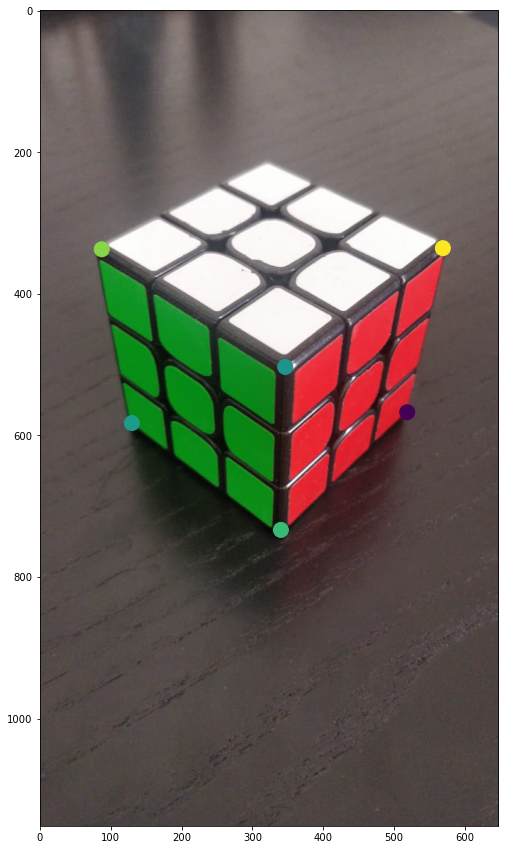

In [83]:
# This cell displays the points you have clicked.
%matplotlib inline
N = len(image_points)
image_points = np.array(image_points)
fig = plt.figure(figsize=(10,15))

img=mpimg.imread('data/1/dlt1.jpeg')
imgplot = plt.imshow(img)

colors = np.random.rand(N)
area = (15 * np.ones(N))**2 

plt.scatter(image_points[:,0], image_points[:,1], c=colors, s=area)
plt.show()

In [13]:
def retHomoCoord(points):
    ones = np.ones((points.shape[0], 1))    
    return np.hstack((points, ones))

In [85]:
worldCoords = np.array([[0,0,0], [4,0,0], [4,0,4], [4,4,4], [4,4,0], [0,4,0]])
homoWorldCoords = retHomoCoord(worldCoords) # homogeneous coordinates of world points
homoImagePoints = retHomoCoord(image_points) # homogeneous coordinates of image points

In [86]:
def getMMatrix(homoWorldCoords, homoImagePoints):
    mMatrix = []
    for i in range(homoWorldCoords.shape[0]):
        mMatrix.append([-homoWorldCoords[i][0], -homoWorldCoords[i][1], -homoWorldCoords[i][2], -1, 0, 0, 0, 0, homoImagePoints[i][0]*homoWorldCoords[i][0], homoImagePoints[i][0]*homoWorldCoords[i][1], homoImagePoints[i][0]*homoWorldCoords[i][2], homoImagePoints[i][0]])
        mMatrix.append([0, 0, 0, 0, -homoWorldCoords[i][0], -homoWorldCoords[i][1], -homoWorldCoords[i][2], -1, homoImagePoints[i][1]*homoWorldCoords[i][0], homoImagePoints[i][1]*homoWorldCoords[i][1], homoImagePoints[i][1]*homoWorldCoords[i][2], homoImagePoints[i][1]])
    mMatrix = np.array(mMatrix)
    return mMatrix

def getProjectionMatrix(homoWorldCoords, homoImagePoints):
    mMatrix = getMMatrix(homoWorldCoords, homoImagePoints)
    u, s, v = np.linalg.svd(mMatrix) # SVD of world points
    p = v[-1, : ]/ v[-1, -1] # last row of v is the solution
    p = p.reshape(3, 4) # reshape to 3x4 matrix
    return p

def get_reprojected_points(P, X_world):
    X_image = np.matmul(P, X_world.T)
    return (X_image/X_image[-1, :])[0:2, :].T
    
def visualise(P, X_world, img_path):
    X_image_reprojected = get_reprojected_points(P, X_world)
    img = mpimg.imread(img_path)
    fig = plt.figure(figsize=(10, 15))
    imgPlot = plt.imshow(img)
    colors = np.random.rand(N)
    area = (15 * np.ones(N))**2 
    plt.scatter(X_image_reprojected[:, 0], X_image_reprojected[:, 1], c=colors, s=area)
    plt.show()
        
    
def get_reprojection_err(P, X_world, X_image):
    X_image_reprojected = get_reprojected_points(P, X_world)
    return np.sum((X_image_reprojected - X_image[:, 0:2]) ** 2)/X_world.shape[0]


In [87]:
p = getProjectionMatrix(homoWorldCoords, homoImagePoints) # projection matrix
r = get_reprojected_points(p, homoWorldCoords)
err = get_reprojection_err(p, homoWorldCoords, homoImagePoints) # reprojection error
print(err)

0.8731124113895891


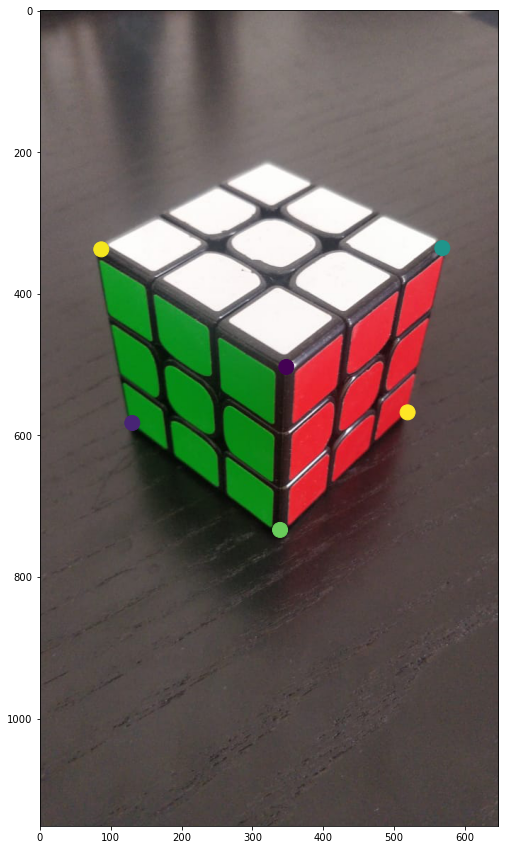

In [88]:
visualise(p, homoWorldCoords, 'data/1/dlt1.jpeg')

In [93]:
def getRKT(P):
    mMatrix = P[:, 0:3]
    mInv = np.linalg.pinv(mMatrix)
    mDash = P[:,-1]
    T = -np.matmul(mInv, mDash)
    rDash, kinv = np.linalg.qr(mInv)
    K = np.linalg.inv(kinv)
    R = rDash.T
    return R,K,T


In [94]:
R, K, T = getRKT(p)
print("Rotation Matrix: ")
print(R)
print("Intrinsic Matrix: ")
print(K)
print("Translation Matrix: ")
print(T)

Rotation Matrix: 
[[-0.7980414  -0.09575501 -0.59494614]
 [ 0.51838092 -0.61250349 -0.59675849]
 [-0.30726397 -0.7846467   0.53844072]]
Intrinsic Matrix: 
[[-7.01752467e+01 -2.37743128e+00  2.98581804e+01]
 [ 0.00000000e+00  7.13060666e+01  4.38428246e+01]
 [ 0.00000000e+00  0.00000000e+00  6.33156932e-02]]
Translation Matrix: 
[ 9.57542794 11.91809493 -6.50061323]


In [95]:
def verifyRKT(R, K, T):
    matrix = np.zeros((3, 4))
    matrix[:3, :3] = R
    matrix[:3, 3] = T.T
    return K @ matrix
    

In [99]:
pProj = verifyRKT(R, K, T)
print("Projection Matrix: ")
print(np.isclose(p, pProj))

Projection Matrix: 
[[ True  True  True False]
 [ True  True  True False]
 [ True  True  True False]]


### RANSAC based DLT
- Random Sample Consensus, also known as RANSAC, is an iterative method for identifying parameters in circumstances where the data may contain anomalies.
- In the DLT technique, we have World-Image correspondences and have presumptively accepted their validity. However, errors in correspondence recognition might happen, leading to outliers that skew the results.
- Ransac algorithm is used to maximize the number of inliers and DLT (Direct Linear Transform) is used to compute Homography.
- Ransac involves the following:
    - Sample randojmly the points required to fit the model
    - Solve for model parameters using samples
    - Score by the fraction of inliers within a present threshold of the model
- The Ransac loop has the following:
    - Get point correspondences randomly.
    - Use DLT to get homography.
    - Count the inliers.
    - Keep the current homography if the number of inlers is maximum.
- Then we can compute H using all inliers.


### Zhang's Method
- In Zhang's technique, we calibrate by taking three distinct images of a calibration target in various positions and orientations. The number of photos needed can be decreased to two if some of the intrinsic characteristics are provided as data (such as the orthogonality of the image or the optical centre coordinates).
- After getting images in different orientations, we first need to detect featurs in the images.
- After that, we need to estimate the five intrinsic parameters and all external parameters using a closed form solution.
- In the next step, we need to estimate the coefficeints of radial distortion by solving linear least squares. 
- Lastly, we need to refine all parameters inclucing lens distortion parameters, mainly by minimizing.  
- The first step involves estimating the projection matrix using methods like DLT. Then we can apply self calibration techniques.
- The significance of Zhang's method is that it can extract a constrained intrinsic and calibration parameters from pose of the calibration target.


# 2. Two view Geometry

For this task, you have been given two images of the same scene taken from different view-points. Refer to below two images and follow the below points for deliverables:
<br>

*Note: For this question you will need to compute the F matrix on your own without using inbuilt functions. The convention used for F is $x'^{T}Fx$ where $x'$ is the location of the point in the second image. File `data/2/camera.txt` has camera parameters in order Fx, Fy, Cx, Cy, Scaling factor*
<br>


<img src="./data/2/rgb000551.jpg" alt="image 1" width="400"/>
<img src="./data/2/rgb000841.jpg" alt="image 2" width="400"/>


1. Estimate the fundamental matrix from these two images. Clearly, write a function named ```compute_fundamental_matrix(X1_list, X2_list)``` that takes feature points from first image and corresponding points from second image i.e. known correspondences. You can compute the correspondences either using Feature detector-descriptor + Feature Matching algorithm from openCV or use code provided in DLT part i.e. handcraft them. Save the obtained matrix.

2. For each point in first image that you used for estimating F matrix, find and plot the corresponding epipolar line on second image. Repeat this for other image as well. 

3. Report the location of the epipoles. Mathematically find the epipoles and verify that the epipolar lines intersect at the epipole. What happens to epipole in case Fundamental matrix is not full rank?

4. Compute all 4 possible solutions of rotation matrix `R` and translation `C` between the two camera's that could be used to obtain the same essential/fundamental matrix by implementing following function: `[R1 C1 R2 C2 R3 C3 R4 C4] = CameraPose(F, K)`; where `F` is the fundamental matrix and `K` is the intrinsic parameter. 

    <img src="./data/2/camera_orientation.png" alt="image 1" width="800"/> <br>


5. **Triangulation:** Given four configurations of relative camera pose, you will find the best camera pose by verifying through 3D point triangulation. Follow the below steps for the same:

    1. Linear triangulation: Write a code that computes the 3D point given the correspondence, u ↔ v, and two camera projection matrices i.e. `[X] = LinearTriangulation(P1,u,P2,v)` Input: `P1, P2 ∈ R3×4` are two camera projection matrices, and `u ↔ v ∈ R2` are their 2D correspondence. Output: `X ∈ R3` is the triangulated 3D point. 

    2. What is cheirality condition and it's importance? Implement the following function for checking cheirality. `idx = CheckCheirality(Y,C,R)` Input: `Y` is a `n × 3` matrix that includes `n` 3D points, and `C,R` is the relative camera pose being checked(camera center and rotation). Output: `idx` is a set of indices of 3D points that satisfy cheirality.
    
    3. Based on cheirality, find the correct relative camera pose and clearly mention the same. Visualize 3D camera pose and 3D points together(It's up to you how you come with visualisation).
    

In [40]:
%matplotlib tk
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import math
import numpy as np
import cv2
import open3d as o3d

In [7]:
img1 = mpimg.imread('data/2/rgb000551.jpg')
img2 = mpimg.imread('data/2/rgb000841.jpg')
cvimg1 = cv2.imread('data/2/rgb000551.jpg')
cvimg2 = cv2.imread('data/2/rgb000841.jpg')

In [8]:
def getClickedPoints(img1, clickedPoints1):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111)
    ax.plot(np.random.rand(6))
    text = ax.text(0, 0, '', va='bottom', ha='left')

    def onclick1(event):
        ix, iy = event.xdata, event.ydata
        clickedPoints1.append([ix, iy])
        text.set_text('x=%1.2f, y=%1.2f' % (ix, iy))

    cid = fig.canvas.mpl_connect('button_press_event', onclick1)
    plt.imshow(img1)
    plt.show()


def showClickedPoints(img1, clickedPoints1):
    N = len(clickedPoints1)
    clickedPoints1 = np.array(clickedPoints1)
    fig = plt.figure(figsize=(10, 10))
    imgplot = plt.imshow(img1)
    colors = np.random.rand(N)
    area = (15 * np.ones(N)) ** 2
    plt.scatter(clickedPoints1[:, 0], clickedPoints1[:, 1], c=colors, s=area)
    plt.show()

In [9]:
clickedPoints1 = []
getClickedPoints(img1, clickedPoints1)
# showClickedPoints(img2, clickedPoints1)

In [10]:
clickedPoints2 = []
getClickedPoints(img2, clickedPoints2)
# showClickedPoints(img1, clickedPoints2)

In [14]:
def retHomoCoord(points):
    ones = np.ones((points.shape[0], 1))    
    return np.hstack((points, ones))
    
def featureMatching(cvimg1, cvimg2, nfeatures):
    orb = cv2.ORB_create(nfeatures=nfeatures)
    kp1, des1 = orb.detectAndCompute(cvimg1, None)
    kp2, des2 = orb.detectAndCompute(cvimg2, None)
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    matches = bf.match(des1, des2)
    matches = sorted(matches, key=lambda x: x.distance)
    return kp1, kp2, matches

def returnAfterNormalize(X1_list):
    X1_list = retHomoCoord(X1_list)
    x1 = np.array(X1_list)
    x1_mean = np.mean(x1, axis=0)
    x1_std = np.std(x1, axis=0)
    T1 = np.array([[1, 0, -x1_mean[0]], [0, 1, -x1_mean[1]], [0, 0, 1]])
    T2 = np.array([[1/x1_std[0], 0, 0], [0, 1/x1_std[1], 0], [0, 0, 1]])
    t = np.matmul(T2, T1)
    x1 = np.matmul(t, x1.T).T
    return np.array(t), np.array(x1)

def compute_fundamental_matrix(x1_list,x2_list):
    numFeat = x1_list.shape[0]
    t1, x1 = returnAfterNormalize(x1_list)
    t2, x2 = returnAfterNormalize(x2_list)
    ans = np.zeros((numFeat,9))
    for i in range(numFeat):
        ans[i] = np.array([x1[i][0]*x2[i][0], x1[i][0]*x2[i][1], x1[i][0], x1[i][1]*x2[i][0], x1[i][1]*x2[i][1], x1[i][1], x2[i][0], x2[i][1], 1])
    u,s,v = np.linalg.svd(ans)
    f = (v[-1]).reshape(3,3)
    u,s,v = np.linalg.svd(f)
    s[2] = 0
    F = np.dot(u,np.dot(np.diag(s),v))
    fundMatrix = t1.T @ F @ t2
    fundMatrix = fundMatrix/fundMatrix[2,2]
    return fundMatrix


In [15]:
# numBestFeatures = 1000
# kp1, kp2, matches = featureMatching(cvimg1, cvimg2, numBestFeatures)
# arr1 = np.array([kp1[match.queryIdx].pt for match in matches])
# arr2 = np.array([kp2[match.trainIdx].pt for match in matches])
# F = compute_fundamental_matrix2(arr1[:8], arr2[:8])
F = compute_fundamental_matrix(np.array(clickedPoints1), np.array(clickedPoints2))
print(F)

[[-9.80905425e-06  1.03203413e-05  2.00842001e-03]
 [-1.45143699e-05 -1.59764814e-05 -2.01641401e-03]
 [-1.95413358e-03  5.81380522e-03  1.00000000e+00]]


In [16]:
val = retHomoCoord(np.array(clickedPoints1)).dot(F).dot(retHomoCoord(np.array(clickedPoints2)).T)
print(np.mean(abs(val)))

0.6299651841078884


In [17]:
def visualize(img,F,x_list1,x_list2, epipoleLines):
    x_list1 = retHomoCoord(np.array(x_list1))
    x_list2 = retHomoCoord(np.array(x_list2))

    cmap = plt.get_cmap('Paired')
    for i in range(x_list1.shape[0]):
        color = cmap(i)
        line = np.dot(F,x_list2[i]).reshape(-1,1)
        epipoleLines.append(line)
        p1 = (0,-line[2]/line[1])
        p2 = (img.shape[1],-(line[0]*img.shape[1] + line[2])/line[1])
        plt.plot(*zip(p1,p2),color = color)
        plt.plot(x_list1[i][:2][0],x_list1[i][:2][1],'o-',color = color)
    plt.imshow(img)

In [18]:
epipoleLines1 = []
visualize(img1,F,clickedPoints1,clickedPoints2, epipoleLines1)

In [19]:
epipoleLines2 = []
visualize(img2,F.T,clickedPoints2,clickedPoints1, epipoleLines2)

In [20]:
def getEpipole(F):
    u,s,v = np.linalg.svd(F)
    return v.T[:,-1]/v.T[:,-1][2]

epipole1 = getEpipole(F.T)
epipole2 = getEpipole(F)
print(epipole1[:2])
print(epipole2[:2])

[-377.165084    120.26007364]
[  36.79325023 -159.63745597]


In [21]:
# Check if epilines intersect at the epipole
def checkEpipole(epipoleLines1):
    for i in range(1, len(epipoleLines1)):
        intersection = np.cross(epipoleLines1[0].T, epipoleLines1[i].T)
        print((intersection/intersection[0, 2])[:, :2].reshape(-1))
    

In [22]:
checkEpipole(epipoleLines1)

[-377.165084    120.26007364]
[-377.165084    120.26007364]
[-377.165084    120.26007364]
[-377.165084    120.26007364]
[-377.165084    120.26007364]
[-377.165084    120.26007364]
[-377.165084    120.26007364]


In [23]:
checkEpipole(epipoleLines2)

[  36.79325023 -159.63745597]
[  36.79325023 -159.63745597]
[  36.79325023 -159.63745597]
[  36.79325023 -159.63745597]
[  36.79325023 -159.63745597]
[  36.79325023 -159.63745597]
[  36.79325023 -159.63745597]


In [24]:
# load a file
def loadFile(filename):
    with open(filename, 'r') as f:
        data = f.read()
    return data

cameraParam = loadFile('data/2/camera.txt')
fx = float(cameraParam.split(' ')[0])
fy = float(cameraParam.split(' ')[1])
cx = float(cameraParam.split(' ')[2])
cy = float(cameraParam.split(' ')[3])
scale = float(cameraParam.split(' ')[4])
# K = intrisic matrix of camera
K = np.array([[fx, 0, cx], [0, fy, cy], [0, 0, 1]])

In [25]:
def get_essential_matrix(F, K):
    E = K.T @ F @ K
    return E

def CameraPose(F, K):
    R = []
    T = []
    E = get_essential_matrix(F, K)
    u, s, v = np.linalg.svd(E)
    W = np.array([[0, -1, 0], [1, 0, 0], [0, 0, 1]])
    Z = np.array([[0, 1, 0], [-1, 0, 0], [0, 0, 0]])
    R.append(u @ W @ v)
    R.append(u @ W.T @ v)
    T.append(u[:, 2])
    T.append(-u[:, 2])
    R.append(u @ W @ v)
    R.append(u @ W.T @ v)
    T.append(-u[:, 2])
    T.append(u[:, 2])
    return R, T


In [26]:
E = get_essential_matrix(F, K)
print(E)
rArray , tArray = CameraPose(F, K)

[[-1.43287322  1.50613987  0.57237772]
 [-2.11821204 -2.32939426 -4.01424411]
 [-3.29342678  1.94103563 -0.30683029]]


In [27]:
def getProj(K, R, T):
    T = np.reshape(T, (3, 1))
    return np.dot(K, np.dot(R, np.hstack((np.eye(3), -T))))

def getReshapedComponents(P1):
    return P1[0,:].reshape(1,4), P1[1,:].reshape(1,4), P1[2,:].reshape(1,4)

def formDMatrix(dMatrix, compArray, x , y):
    dMatrix.append((y * compArray[2]) -  compArray[1])
    dMatrix.append(compArray[0] -  (x * compArray[2]))
    return dMatrix

def LinearTriangulation(R1, T1, R2, T2, x1, x2, K):
    points3d = []

    for i in range(x1.shape[0]):
        dMatrix = []
        dMatrix = formDMatrix(dMatrix, getReshapedComponents(getProj(K, R1, T1)), x1[i, 0], x1[i, 1])
        dMatrix = formDMatrix(dMatrix, getReshapedComponents(getProj(K, R2, T2)), x2[i, 0], x2[i, 1])
        dMatrix = np.array(dMatrix).reshape(4,4)

        s,d,v = np.linalg.svd(dMatrix)
        points3d.append(v.T[:, -1])
    
    return np.array(points3d)

def get3dPoints(R, T, points):
    rot = R[2, :].reshape(1, -1)
    trans = T.reshape(-1, 1)
    points = points[: , :3]
    return trans, rot, points

def checkCheirality(points3d, rArray, tarray):
    ind = 0
    maxDepth = -1e9
    for i in range(len(rArray)):
        trans, rot, x3d = get3dPoints(rArray[i], tarray[i], points3d[i] / points3d[i][:, 3].reshape(-1, 1))
        n_positive_depth = np.sum(rot.dot(x3d.T - trans) > 0)
        if n_positive_depth > maxDepth:
            ind = i
            maxDepth = n_positive_depth
    R, T, x3d = rArray[ind], tarray[ind], points3d[ind]
    return R, T, x3d, ind

In [28]:
rtemp = np.identity(3)
ttemp = np.zeros(3)
points3d = []
for i in range(len(rArray)):
    X = LinearTriangulation(rtemp, ttemp, rArray[i], tArray[i], np.array(clickedPoints1), np.array(clickedPoints2), K)
    X = X/X[:, 3].reshape(-1, 1)
    points3d.append(X)
rdash , tdash, X, ind = checkCheirality(points3d, rArray, tArray)

In [29]:
def visualize3dPoints(X):
    X = X[: , :3]
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(X[:, 0], X[:, 1], X[:, 2])
    plt.show()
    

In [ ]:
visualize3dPoints(X)

# 3. Stereo Dense Reconstruction

3-D point clouds are very useful in robotics for several tasks such as object detection, motion estimation (3D-3D matching or 3D-2D matching), SLAM, and other forms of scene understanding.  Stereo cameras provide  us  with  a  convenient  way  to  generate  dense  point  clouds. Dense here,  in  contrast  to sparse, means all the image points are used for the reconstruction.  In this part of the assignment you will be generating a dense 3D point cloud reconstruction of a scene from stereo images. Refer `data/4` folder. It contains `img2` and `img3` folder for left and right stereo image respectively. `poses.txt` contains flatten 12 values of transformation matrix for each pose and `calib.txt` contains `K & Baseline`.

### Procedure


1. Generate a disparity map for all given stereo pair.  Use OpenCV (e.g.  StereoSGBM) for this.  Note that the images provided are already rectified and undistorted.
2. Then, using the camera parameters and baseline information generate colored point clouds from each disparity map.  Some points will have invalid disparity values, so ignore them. Use `Open3D` for storing your point clouds.
3. Register (or transform) all the generated point clouds into your world frame by using the provided ground truth poses.
4. Visualize the registered point cloud data, in color.  Use Open3D for this.

    
    
Write briefly about how the disparity map is generated (if you used SGBM, write about SGBM).

In [41]:
import open3d as o3d
import numpy as np
import os
import cv2

In [42]:
# Intrinsic parameters given in calib txt file
intrinsics = [7.070912e+02, 0.000000e+00, 6.018873e+02, 0.000000e+00, 7.070912e+02, 1.831104e+02, 0.000000e+00, 0.000000e+00, 1.000000e+00]
K = np.array(intrinsics).reshape(3, 3)
Kinv = np.linalg.pinv(K)
baseline = 0.53790448812
dir1 = 'data/4/img2/'
dir2 = 'data/4/img3/'
posesFile = 'data/4/poses.txt'

In [44]:
def obtainImages(dir1):
    filenames = []
    for filename in os.listdir(dir1):
        img = os.path.join(dir1, filename)
        filenames.append(img)
    filenames.sort()
    images = []
    for filenmame in filenames:
        image = cv2.imread(filenmame)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        images.append(image)
    return images

def readAllPoses(fileName):
    poses = []
    with open(fileName, 'r') as f:
        for line in f:
            temp = line.split(' ')
            temp = np.array(temp).reshape(3, 4)
            poses.append(temp)
    poses = [np.vstack((pose, np.array([0, 0, 0, 1]))) for pose in poses]
    poses = np.array(poses)
    poses = poses.astype('float64')
    return poses    

def getDisparity(leftImage, rightImage):
    win_size = 3
    min_disp = 16
    num_disp = 144 - min_disp
    blockSize = 7
    disp12MaxDiff = 1
    uniquenessRatio = 12
    speckleWindowSize = 400
    speckleRange = 5

    stereo = cv2.StereoSGBM_create(
                            minDisparity=min_disp, numDisparities=num_disp, blockSize=blockSize, disp12MaxDiff=disp12MaxDiff, 
                            speckleWindowSize=speckleWindowSize, speckleRange=speckleRange,
                            uniquenessRatio=uniquenessRatio, P1=8*3*win_size**2, P2=32*3*win_size**2)
    disparity = stereo.compute(leftImage, rightImage).astype(np.float32) / 16.0
    return disparity


def convertToWorldCoordinates(pcd, currPose):
    R = np.array([[-1, 0, 0], [0, -1, 0], [0, 0, 1]])
    points = np.array(pcd.points)
    homopoints = np.hstack((points, np.ones((points.shape[0], 1))))
    homopoints = currPose @ homopoints.T
    homopoints = homopoints.T
    homopoints = homopoints[:, :3]/ homopoints[:, 3, np.newaxis]
    homopoints = R @ homopoints.T
    homopoints = homopoints.T
    pcdNew = o3d.geometry.PointCloud()
    pcdNew.points = o3d.utility.Vector3dVector(homopoints)
    pcdNew.colors = pcd.colors
    return pcdNew

In [49]:
poses = readAllPoses(posesFile)
leftImages = obtainImages(dir1)
rightImages = obtainImages(dir2)

In [57]:
pcds = []
pcdPoints = []
pcdColors = []
f = K[0,0]
for i in range(len(leftImages)):
    leftImage = leftImages[i]
    rightImage = rightImages[i]
    disparity = getDisparity(leftImage, rightImage)
    colors = cv2.cvtColor(leftImage, cv2.COLOR_GRAY2RGB)/255.0
    colors = colors[disparity!=None]
    h,w = disparity.shape
    dispMatrix = np.float32([[ 1,  0,  0, -w/2],
                    [ 0,  -1,  0, h/2],
                    [ 0,  0,  0, f],
                    [ 0,  0,  1/baseline, 0]])
    currPcd = cv2.reprojectImageTo3D(disparity, dispMatrix)
    currPcd = currPcd.reshape((-1, 3))
    currPcd = np.hstack((currPcd, np.ones((currPcd.shape[0],1))))
    for j in range(currPcd.shape[0]):
        obtainedPose = poses[i] @ currPcd[j].T
        if(obtainedPose[3] < 0):
            continue
        pcdPoints.append(obtainedPose[:3]/obtainedPose[3])
        pcdColors.append(colors[j])

In [59]:
pcdPoints = np.array(pcdPoints)
pcdColors = np.array(pcdColors)
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(pcdPoints)
pcd.colors = o3d.utility.Vector3dVector(pcdColors)

In [61]:
o3d.visualization.draw_geometries([pcd])